# COURSE: A deep understanding of deep learning
## SECTION: Generative adversarial networks
### LECTURE: Linear GAN with MNIST
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202212

#Task
- using the same architecture, train the GAN using the the FMNIST dataset
- train on 3 image classes bu keep the full dataset
- use dataloader and batches (train 50k batches)
- smooth the loss function

In [17]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import Subset, DataLoader
import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-17-962647415372>:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Import the data

In [19]:
batch_size = 100

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_set = datasets.FashionMNIST(root='./data', train=True, download = True, transform=transform)



In [20]:
tsp_class_indices = [1,2,7]
tss_class_indices = [1,7,5]

def filter_dataset(dataset, classesToKeep):
  indices = [i for i, (img,label) in enumerate(dataset) if label in classesToKeep]
  return Subset(dataset, indices)

tsp_data = filter_dataset(train_set, tsp_class_indices)
tss_data = filter_dataset(train_set, tss_class_indices)
tsp_data_loader = DataLoader(tsp_data,batch_size=batch_size,drop_last=True)
tss_data_loader = DataLoader(tss_data,batch_size=batch_size,drop_last=True)


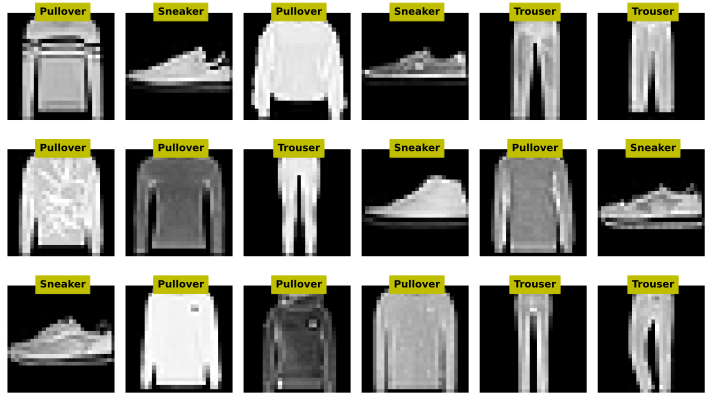

In [23]:
# view some images
# inspect a few random images

X,y = next(iter(tsp_data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train_set.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

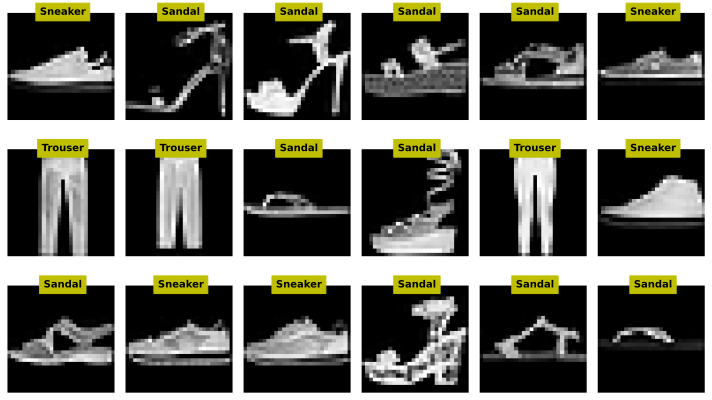

In [24]:
# view some images
# inspect a few random images

X,y = next(iter(tss_data_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = train_set.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Create classes for the discriminator and generator

In [10]:
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.sigmoid( x )

dnet = discriminatorNet()
y = dnet(torch.randn(10,784))
y

tensor([[0.5154],
        [0.5057],
        [0.5133],
        [0.5030],
        [0.4825],
        [0.5203],
        [0.4996],
        [0.4883],
        [0.5394],
        [0.5120]], grad_fn=<SigmoidBackward0>)

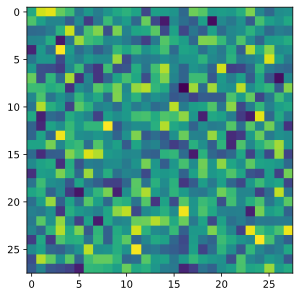

In [11]:
class generatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(64,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x) )
    x = F.leaky_relu( self.fc2(x) )
    x = self.out(x)
    return torch.tanh( x )


gnet = generatorNet()
y = gnet(torch.randn(10,64))
plt.imshow(y[0,:].detach().squeeze().view(28,28));

# Train the models! --> Trousers Sneakers Pullover


In [12]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:
# this cell takes ~3 mins with 50k epochs
num_epochs = int(50000/len(tsp_data_loader))

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):
  for data,_ in tsp_data_loader:
  # create minibatches of REAL and FAKE images
  # randidx     = torch.randint(tsp_data.shape[0],(batch_size,))
  # real_images = tsp_data[randidx,:].to(device)

    data = data.view(batch_size,1).to(device) #making 2d tensor into linear vector for the linear GAN
    # labels used for real and fake images
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)              # REAL images into discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_images = gnet( torch.randn(batch_size,64).to(device) ) # output of generator
    pred_fake   = dnet(fake_images)              # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi,0]  = d_loss.item()
    disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()




    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batch_size,64).to(device) )
    pred_fake   = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake,real_labels)
    losses[epochi,1]  = g_loss.item()
    disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # print out a status message
    if (epochi+1)%500==0:
      msg = f'Finished epoch {epochi+1}/{num_epochs}'
      sys.stdout.write('\r' + msg)


In [25]:
def smooth(x,k=15):
  return np.convolve(x, np.ones(k)/k, mode='same')

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(18,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,5000])

ax[1].plot(losses[::5,0],losses[::5,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

ax[2].plot(disDecs)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probablity ("real")')
ax[2].set_title('Discriminator output')
ax[2].legend(['Real','Fake'])

plt.show()

# Let's see some fake digits!

In [ ]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(12,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,4,figsize=(8,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.show()

#Train the Models --> Trousers Sneakers Sandels

In [ ]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models
dnet = discriminatorNet().to(device)
gnet = generatorNet().to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [ ]:
# this cell takes ~3 mins with 50k epochs
num_epochs = int(50000/len(tss_data_loader))

losses  = np.zeros((num_epochs,2))
disDecs = np.zeros((num_epochs,2)) # disDecs = discriminator decisions

for epochi in range(num_epochs):
  for data,_ in tss_data_loader:
  # create minibatches of REAL and FAKE images
  # randidx     = torch.randint(tsp_data.shape[0],(batch_size,))

    data = data.view(batch_size,1).to(device) #making 2d tensor into linear vector for the linear GAN
    # labels used for real and fake images
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)



    ### ---------------- Train the discriminator ---------------- ###

    # forward pass and loss for REAL pictures
    pred_real   = dnet(data)              # REAL images into discriminator
    d_loss_real = lossfun(pred_real,real_labels) # all labels are 1

    # forward pass and loss for FAKE pictures
    fake_images = gnet( torch.randn(batch_size,64).to(device) ) # output of generator
    pred_fake   = dnet(fake_images)              # FAKE images into discriminator
    d_loss_fake = lossfun(pred_fake,fake_labels) # all labels are 0

    # collect loss (using combined losses)
    d_loss = d_loss_real + d_loss_fake
    losses[epochi,0]  = d_loss.item()
    disDecs[epochi,0] = torch.mean((pred_real>.5).float()).detach()

    # backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()




    ### ---------------- Train the generator ---------------- ###

    # create fake images and compute loss
    fake_images = gnet( torch.randn(batch_size,64).to(device) )
    pred_fake   = dnet(fake_images)

    # compute and collect loss and accuracy
    g_loss = lossfun(pred_fake,real_labels)
    losses[epochi,1]  = g_loss.item()
    disDecs[epochi,1] = torch.mean((pred_fake>.5).float()).detach()

    # backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()


    # print out a status message
    if (epochi+1)%500==0:
      msg = f'Finished epoch {epochi+1}/{num_epochs}'
      sys.stdout.write('\r' + msg)


#Results - no gpu :(

## trousers, sneakers, pullovers
- creates some pretty good images
- the quality of the images are grainy
- typical loss dynamics

## trouser, sneakers, sandles
- no outputs look like trousers
- unbalanced classes where the shoes were over represented
- called mode collapse --> all outputs started looking like shoes
- causes the trouser class to dissapear
- caused the random input to always tend towrad the shoes

##In General
- higher qualitative performacne on numbers was better than on the fasion set
- perhaps 2 layer linear network lacks depth to produce complex fashion images
- over training from too many epochs causes the losses to diverge --> generator performance decreases while the discriminator improves